## **Wykrywanie naczyń dna siatkówki oka**

*1. Przetwarzanie obrazu, segmentacja poprzez progowanie*

*2. Modele DecisionTree / kNN / RandomForest / MLP z wykorzystaniem oryginalnej ekstrakcji cech*

*3. Model o architekturze CNN (UNet)*

### *1. Przetwarzanie obrazu, segmentacja poprzez progowanie*

### *Biblioteki*

In [2]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

### *Funkcje*

In [2]:
def show_image(image, title=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title) if title else None
    plt.axis('off')
    plt.show()

- przykładowa instancja

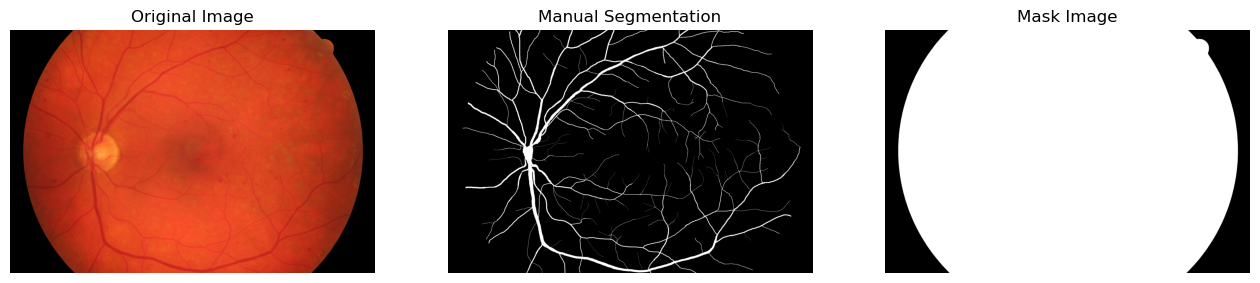

Szerokość obrazu: 3504
Wysokość obrazu: 2336
Szerokość obrazu maski: 3504
Wysokość obrazu maski: 2336


In [3]:
image_path = 'HRF-database/images/01_dr.JPG'
originalImage = cv2.imread(image_path)

segmentedImage_path = 'HRF-database/manual1/01_dr.tif'
segmentedImage = cv2.imread(segmentedImage_path)

mask_path = 'HRF-database/mask/01_dr_mask.tif'
maskImage = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(16, 12))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(segmentedImage, cv2.COLOR_BGR2RGB))
plt.title('Manual Segmentation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(maskImage, cmap='gray')
plt.title('Mask Image')
plt.axis('off')

plt.show()

print("Szerokość obrazu:", originalImage.shape[1])
print("Wysokość obrazu:", originalImage.shape[0])

print("Szerokość obrazu maski:", maskImage.shape[1])
print("Wysokość obrazu maski:", maskImage.shape[0])


- usunięcie tła 

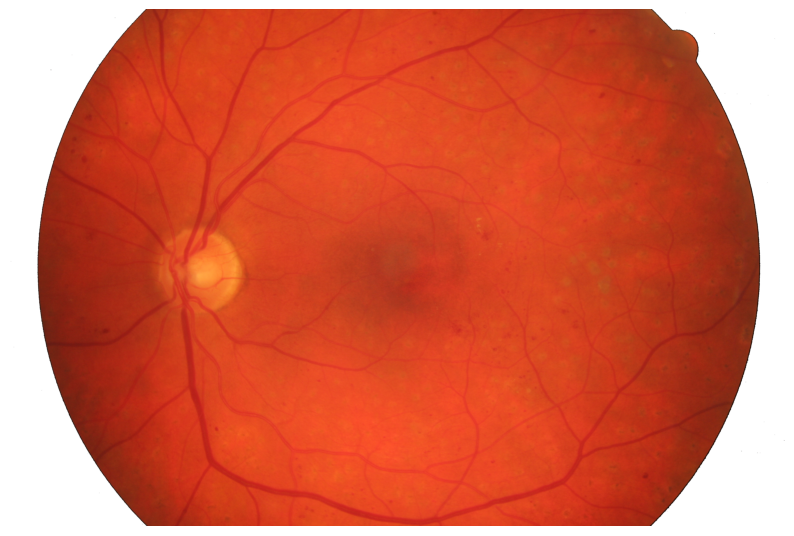

In [4]:
image = originalImage.copy()
threshold = 6 # Próg dla każdego kanału kolorów

image[np.where((originalImage < threshold).all(axis=2))] = [255, 255, 255] # transformacja

show_image(image)

- filtr Gamma

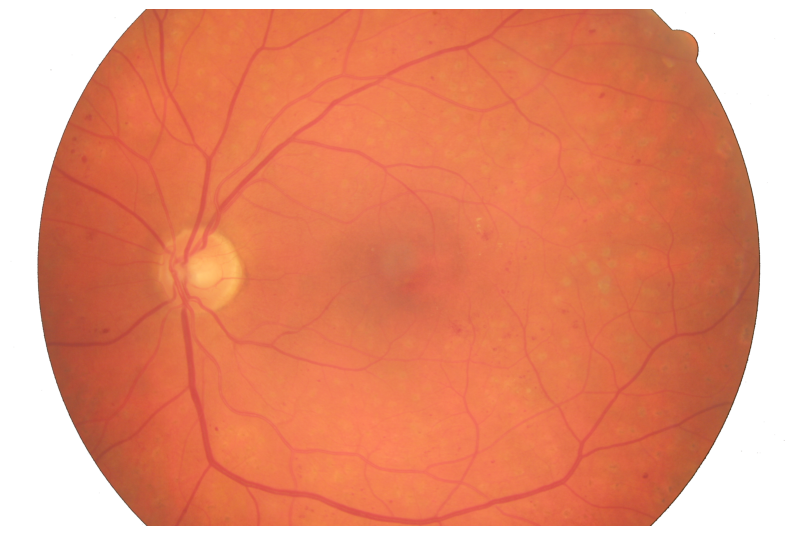

In [5]:
gamma = 1.75
gamma_corrected_image = np.uint8(((image / 255.0) ** (1 / gamma)) * 255)
show_image(gamma_corrected_image)

- Konwersja do skali szarości

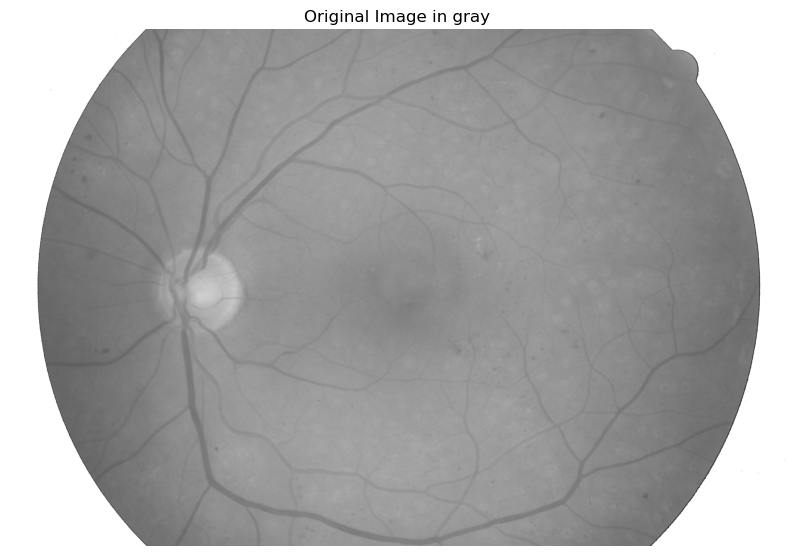

In [6]:
gray = cv2.cvtColor(gamma_corrected_image, cv2.COLOR_BGR2GRAY)
show_image(gray, title='Original Image in gray')

- wyostrzenie obrazu:

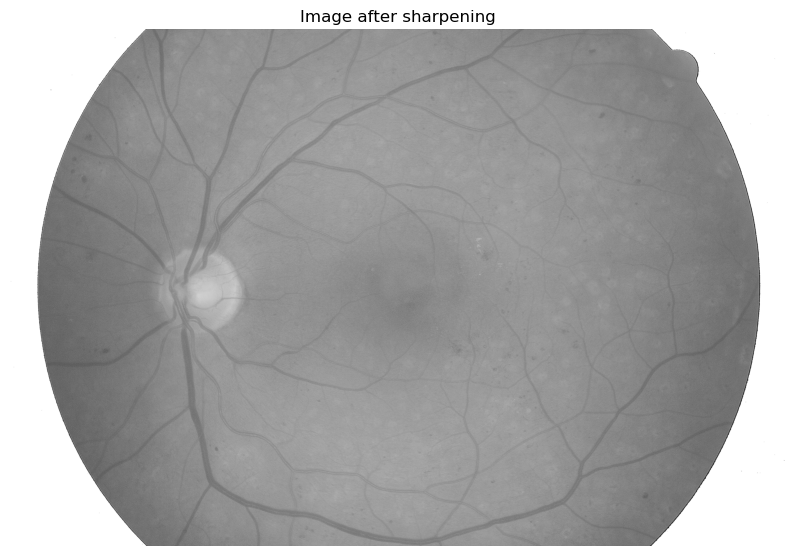

In [7]:
sharp_image = cv2.filter2D(gray, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
show_image(sharp_image, title='Image after sharpening')

- zwiększenie kontrastu - CLAHE

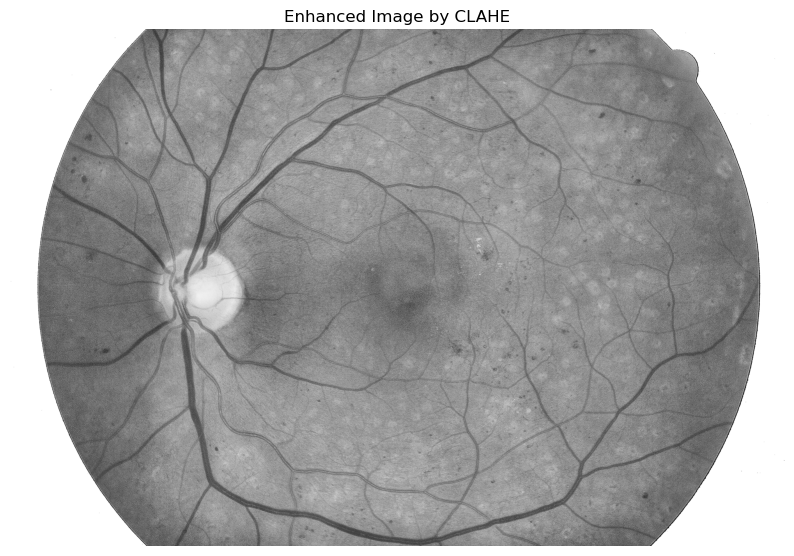

In [8]:
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced_image = clahe.apply(sharp_image)
show_image(enhanced_image, title='Enhanced Image by CLAHE') # Contrast Limited Adaptive Histogram Equalization

- filtr bilateralny:

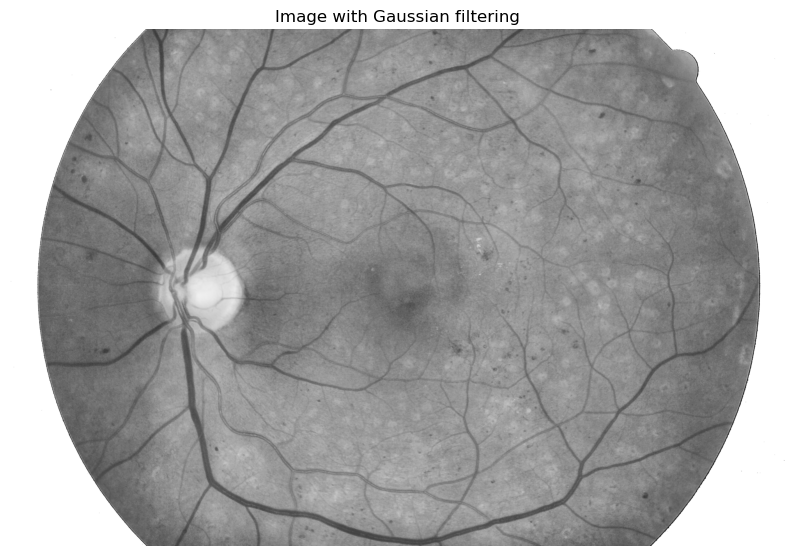

In [9]:
bilateralFiltered = cv2.bilateralFilter(enhanced_image,9,50,50)
show_image(bilateralFiltered, title='Image with Gaussian filtering')

- segmentacja poprzez progowanie:

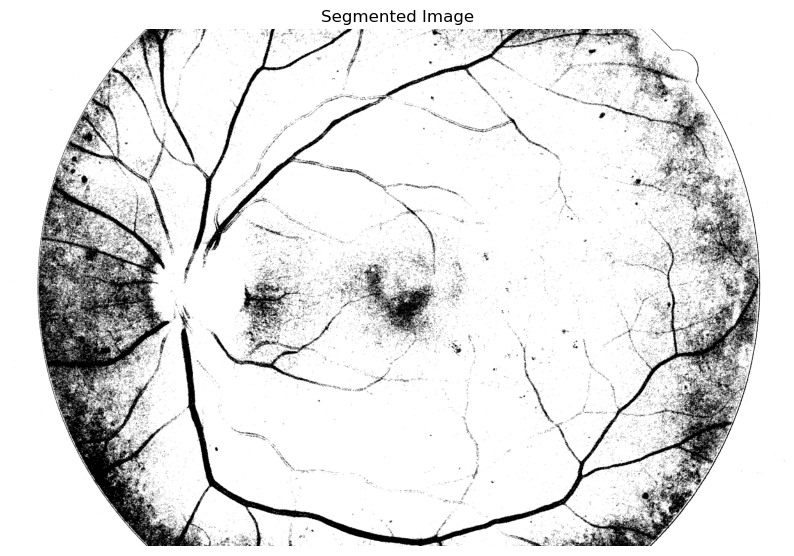

In [10]:
threshold_value = 110 # Ustalenie progu

_, segmented_image = cv2.threshold(bilateralFiltered, threshold_value, 255, cv2.THRESH_BINARY) 

show_image(segmented_image, title='Segmented Image')

- Odwrócenie kolorów:

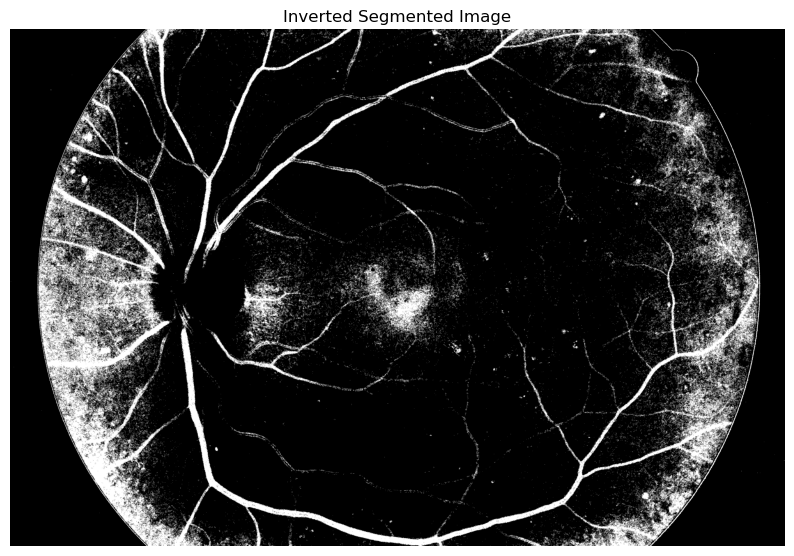

In [11]:
inverted_segmented_image = 255 - segmented_image
show_image(inverted_segmented_image, title='Inverted Segmented Image')

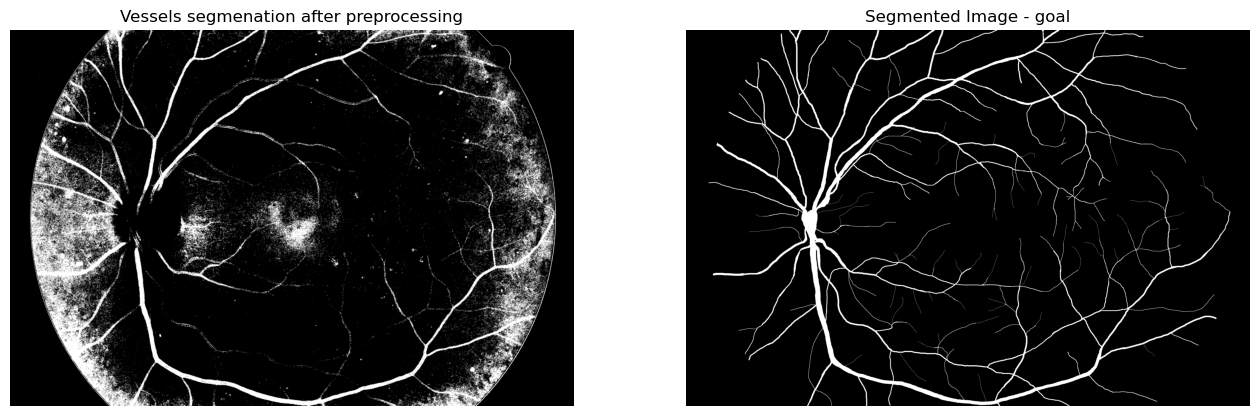

Inverted Segmented Image:
  White pixels: 1039829
  Black pixels: 7145515

Expert's segmented Image (tif_array):
  White pixels: 416282
  Black pixels: 7769062


In [12]:
tif_image_path = "HRF-database/manual1/01_dr.tif"
tif_image = Image.open(tif_image_path)

# Konwersja obrazu PIL do numpy array
tif_array = np.array(tif_image)

plt.figure(figsize=(16, 12))

plt.subplot(1, 2, 1)
plt.imshow(inverted_segmented_image, cmap='gray')
plt.title('Vessels segmenation after preprocessing')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tif_array, cmap='gray')
plt.title('Segmented Image - goal')
plt.axis('off')

plt.show()

white_pixels_inv_seg = np.sum(inverted_segmented_image == 255)
black_pixels_inv_seg = np.sum(inverted_segmented_image == 0)

white_pixels_tif = np.sum(tif_array == 255)
black_pixels_tif = np.sum(tif_array == 0)

print("Inverted Segmented Image:")
print(f"  White pixels: {white_pixels_inv_seg}")
print(f"  Black pixels: {black_pixels_inv_seg}")

print("\nExpert's segmented Image (tif_array):")
print(f"  White pixels: {white_pixels_tif}")
print(f"  Black pixels: {black_pixels_tif}")

In [15]:
total_pixels = white_pixels_inv_seg + black_pixels_inv_seg

correctly_classified = np.where(inverted_segmented_image == tif_array)[0].shape[0]

accuracy = correctly_classified / total_pixels
true_positives = np.sum((inverted_segmented_image == 255) & (tif_array == 255))
false_positives = np.sum((inverted_segmented_image == 255) & (tif_array == 0))
false_negatives = np.sum((inverted_segmented_image == 0) & (tif_array == 255))

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.8750

Precision: 0.2081
Recall: 0.5199


### 2. Ekstrakcja cech + klasyfikator do porównań z CNN (DT / kNN / RF / MLP)

In [3]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import random

- Funkcja do ekstrakcji cech dla piksela i jego otoczenia

In [35]:
def extract_features(image, i, j):
    # Pixel
    pixel_value = image[i, j]

    # Patch 4x4
    patch = image[i-1:i+3, j-1:j+3]

    # features: jasność, średnia z otoczenia, odchylenie standardowe, kontrast
    features = [np.mean(pixel_value), np.mean(patch), np.std(patch)]

    # Grayscale patch and contrast
    gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    features.append(contrast)

    return features

In [23]:
images_path = 'HRF-database/images/'
segmented_images_path = 'HRF-database/manual1/'

original_images = []
segmentation_images = []

for filename in os.listdir(images_path):
    # original image
    if filename.endswith('.JPG') or  filename.endswith('.jpg'):
        original_image = cv2.imread(os.path.join(images_path, filename))
        original_images.append(original_image)

for filename in os.listdir(segmented_images_path):
    # segmented image
    if filename.endswith('.tif'):
        segmented_image_path = os.path.join(segmented_images_path, filename)
        segmented_image = cv2.imread(segmented_image_path, cv2.IMREAD_GRAYSCALE)
        
        if segmented_image is not None:
            segmentation_images.append(segmented_image)
        else:
            print(f"Error loading segmentation image: {filename}")

print(len(original_images))
print(len(segmentation_images))

45
45


In [43]:
features_list = []
labels_list = []

step_size = 5

for original_image, segmentation_image in tqdm(zip(original_images, segmentation_images), total=len(original_images)):
    black_pixel_counter = 0  # Counter for black pixels encountered

    # Iterating through pixels
    for i in range(1, original_image.shape[0]-1, step_size):
        for j in range(1, original_image.shape[1]-1, step_size):
            # Label
            label = segmentation_image[i, j] // 255  # 0: black, 1: white

            if label == 0:
                black_pixel_counter += 1
                if black_pixel_counter % 5 != 0:  # Consider only pixels where remainder is not 0 (every 5th)
                    continue

            # Feature extraction 
            features = extract_features(original_image, i, j)
            features_list.append(features)
            labels_list.append(label)

    # Reset counter after processing each image
    black_pixel_counter = 0

100%|██████████| 45/45 [1:08:53<00:00, 91.86s/it] 


In [45]:
features_arr = np.array(features_list)
labels_arr = np.array(labels_list)

np.save("features.npy", features_arr)
np.save("labels.npy", labels_arr)

In [4]:
# Wczytanie danych
features_arr = np.load("features.npy")
labels_arr = np.load("labels.npy")

In [6]:
# Normalizing features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(features_arr)

- Dataset

In [7]:
X = np.array(X_normalized)
y = np.array(labels_arr)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Decision Tree Classifier

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83    544378
           1       0.59      0.21      0.31    226540

    accuracy                           0.72    770918
   macro avg       0.66      0.57      0.57    770918
weighted avg       0.70      0.72      0.67    770918

Drzewo decyzyjne:


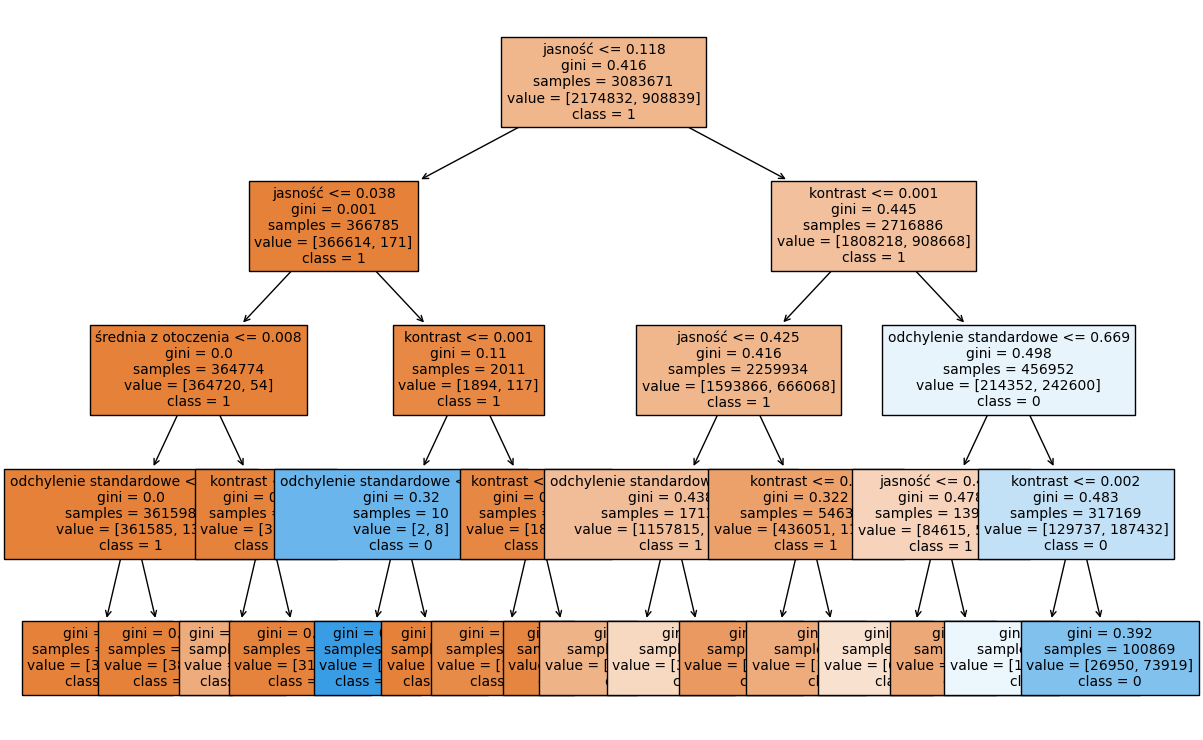

In [14]:
classifier = DecisionTreeClassifier(max_depth=4, criterion = 'gini', random_state=42)

classifier.fit(X_train, y_train)

fig_size = (12, 9)
font_size = 10

feature_names = ['jasność', 'średnia z otoczenia', 'odchylenie standardowe', 'kontrast']

plt.figure(figsize=fig_size)
plot_tree(classifier, 
          feature_names=feature_names,
          class_names=['1', '0'], 
          filled=True, proportion=False, fontsize=font_size)

plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)

print("Decision Tree Classification Report:")
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

print("Drzewo decyzyjne:")
plt.show()

- RandomForestClassifier

In [79]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

classifier.fit(X_train, y_train)

print("Random Forest Classification Report:")
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83    544378
           1       0.59      0.41      0.49    226540

    accuracy                           0.74    770918
   macro avg       0.69      0.65      0.66    770918
weighted avg       0.73      0.74      0.73    770918



- K-Nearest Neighbors

In [43]:
classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean', algorithm='auto')

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("K-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred))

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82    544378
           1       0.55      0.38      0.45    226540

    accuracy                           0.73    770918
   macro avg       0.66      0.62      0.63    770918
weighted avg       0.70      0.73      0.71    770918



- The multilayer perceptron (MLP)

In [15]:
classifier = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=1000, random_state=42)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("MLP Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84    544378
           1       0.63      0.44      0.52    226540

    accuracy                           0.76    770918
   macro avg       0.71      0.67      0.68    770918
weighted avg       0.75      0.76      0.75    770918



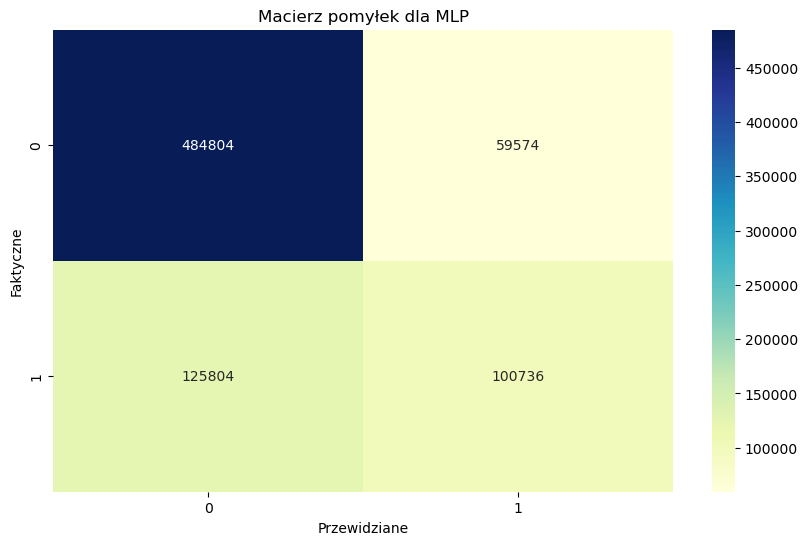

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Obliczanie procentowego udziału
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title("Macierz pomyłek dla MLP (w procentach)")
plt.xlabel("Przewidziane")
plt.ylabel("Faktyczne")
plt.show()

- model MLP dla obrazu po processingu: 

In [14]:
def process_raw_images(images_path, processed_images_path):
    processed_images = []
    for file in os.listdir(images_path):
        # original image
        if file.endswith('.JPG') or  file.endswith('.jpg'):
            original_image = cv2.imread(os.path.join(images_path, file))
            image = original_image.copy()
            
            # backgrounnd 
            threshold = 6 # Próg dla każdego kanału kolorów
            image[np.where((originalImage < threshold).all(axis=2))] = [255, 255, 255]
            
            # gamma filter
            gamma = 1.75
            gamma_corrected_image = np.uint8(((image / 255.0) ** (1 / gamma)) * 255)
            
            # to gray
            gray = cv2.cvtColor(gamma_corrected_image, cv2.COLOR_BGR2GRAY)

            # sharpening
            sharp_image = cv2.filter2D(gray, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
            
            # CLAHE
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
            enhanced_image = clahe.apply(sharp_image)
            
            # bilateral filter
            bilateralFiltered = cv2.bilateralFilter(enhanced_image,9,50,50)
            
            # Save processed image
            processed_images.append(bilateralFiltered)
            cv2.imwrite(os.path.join(processed_images_path, file), bilateralFiltered)

In [15]:
images_path = 'HRF-database/images/'
processed_images_path = 'HRF-database/processed_images/'

process_raw_images(images_path, processed_images_path)

In [16]:
processed_images_path = 'HRF-database/processed_images/'
segmented_images_path = 'HRF-database/manual1/'

processed_images = []
segmentation_images = []

for filename in os.listdir(processed_images_path):
    # original image
    if filename.endswith('.JPG') or  filename.endswith('.jpg'):
        img = cv2.imread(os.path.join(processed_images_path, filename))
        processed_images.append(img)

for filename in os.listdir(segmented_images_path):
    # segmented image
    if filename.endswith('.tif'):
        segmented_image_path = os.path.join(segmented_images_path, filename)
        segmented_image = cv2.imread(segmented_image_path, cv2.IMREAD_GRAYSCALE)
        
        if segmented_image is not None:
            segmentation_images.append(segmented_image)
        else:
            print(f"Error loading segmentation image: {filename}")

print(len(processed_images))
print(len(segmentation_images))

45
45


In [17]:
features_list_processed = []
labels_list = []

step_size = 5

for processed_img, segmentation_image in tqdm(zip(processed_images, segmentation_images), total=len(processed_images)):
    black_pixel_counter = 0  # Counter for black pixels encountered

    # Iterating through pixels
    for i in range(1, processed_img.shape[0]-1, step_size):
        for j in range(1, processed_img.shape[1]-1, step_size):
            # Label
            label = segmentation_image[i, j] // 255  # 0: black, 1: white

            if label == 0:
                black_pixel_counter += 1
                if black_pixel_counter % 5 != 0:  # Consider only pixels where remainder is not 0 (every 5th)
                    continue

            # Feature extraction 
            features = extract_features(processed_img, i, j)
            features_list_processed.append(features)
            labels_list.append(label)

    # Reset counter after processing each image
    black_pixel_counter = 0

100%|██████████| 45/45 [35:05<00:00, 46.79s/it]


In [18]:
# Normalizing features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(features_list_processed)

In [19]:
# Dataset
X = np.array(X_normalized)
y = np.array(labels_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87    544378
           1       0.72      0.60      0.66    226540

    accuracy                           0.82    770918
   macro avg       0.78      0.75      0.76    770918
weighted avg       0.81      0.82      0.81    770918



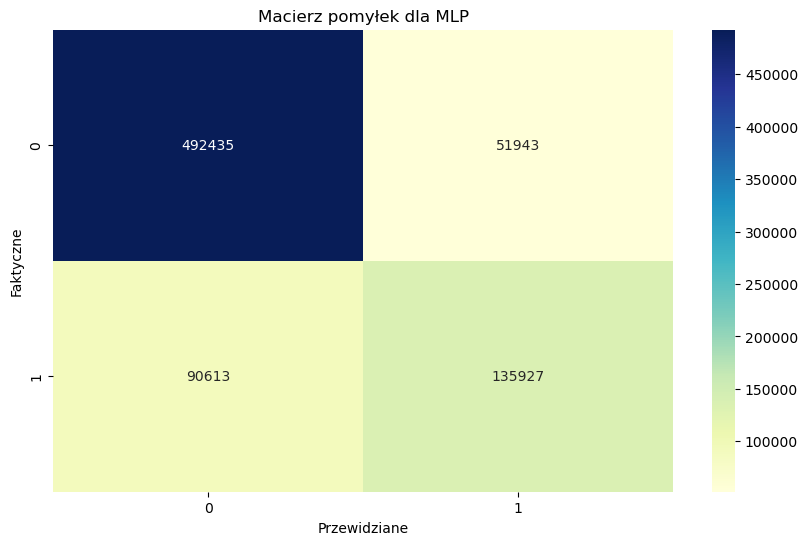

In [20]:
classifier = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=1000, random_state=42)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("MLP Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Obliczanie procentowego udziału
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title("Macierz pomyłek dla MLP (w procentach)")
plt.xlabel("Przewidziane")
plt.ylabel("Faktyczne")
plt.show()

### 3. Model głębokiej konwolucyjnej sieci neuronowej

- U-Net architecture:

In [1]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model

def create_unet(input_shape=(None, None, 3)):
    # Encoder
    inputs = Input(input_shape)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # bottleneck
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)  

    # Decoder
    up1 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2), conv1], axis=3)
    conv3 = Conv2D(32, 3, activation='relu', padding='same')(up1)
    conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv3)
    conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv3)
    conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv3)  
    outputs = Conv2D(1, 1, activation='sigmoid')(conv3)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

unet_model = create_unet()

In [2]:
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        896 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,248 │ conv2d[0][0]      │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │      9,248 │ conv2d_1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │     18,496 │ max_pooling2d[0]… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │     36,928 │ conv2d_3[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │     36,928 │ conv2d_4[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, None,      │     36,928 │ conv2d_5[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, None,      │      8,224 │ conv2d_6[0][0]    │
│ (Conv2DTranspose)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ conv2d_transpose… │
│ (Concatenate)       │ None, 64)         │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, None,      │     18,464 │ concatenate[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, None,      │      9,248 │ conv2d_7[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, None,      │      9,248 │ conv2d_8[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, None,      │      9,248 │ conv2d_9[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, None,      │         33 │ conv2d_10[0][0]   │
│                     │ None, 1)          │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 203,137 (793.50 KB)

 Trainable params: 203,137 (793.50 KB)

 Non-trainable params: 0 (0.00 B)

- dataset:

In [8]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

images_path = 'HRF-database/images/'
segmented_images_path = 'HRF-database/manual1/'

original_images = []
segmentation_images = []

# 25% of original
target_height = 584
target_width = 876

# Wczytaj obrazy oryginalne i obrazy segmentacji
for filename in os.listdir(images_path):
    if filename.endswith('.JPG') or filename.endswith('.jpg'):
        original_image = cv2.imread(os.path.join(images_path, filename))
        if original_image is not None:
            resized_image = cv2.resize(original_image, (target_width, target_height))
            original_images.append(resized_image)
        else:
            print(f"Error loading image: {filename}")

for filename in os.listdir(segmented_images_path):
    if filename.endswith('.tif'):
        segmented_image_path = os.path.join(segmented_images_path, filename)
        segmented_image = cv2.imread(segmented_image_path, cv2.IMREAD_GRAYSCALE)
        if segmented_image is not None:
            resized_segmented_image = cv2.resize(segmented_image, (target_width, target_height))
            segmentation_images.append(resized_segmented_image)
        else:
            print(f"Error loading segmentation image: {filename}")

X_train, X_val, y_train, y_val = train_test_split(original_images, segmentation_images, test_size=0.2, random_state=42)

X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255

# Dodanie wymiaru kanału dla binarnych etykiet (maski segmentacji)
y_train = np.expand_dims(y_train, axis=-1) / 255
y_val = np.expand_dims(y_val, axis=-1) / 255

print("Liczba obrazów treningowych:", len(X_train))
print("Liczba obrazów walidacyjnych:", len(X_val))

Liczba obrazów treningowych: 36
Liczba obrazów walidacyjnych: 9


In [9]:
pred_image = y_val[0]  # Get the first predicted image
print("Minimum value:", np.min(pred_image))
print("Maximum value:", np.max(pred_image))
image_shape = np.shape(y_val[0])
print("Format obrazów w y_pred:", image_shape)

Minimum value: 0.0
Maximum value: 1.0
Format obrazów w y_pred: (584, 876, 1)


In [10]:
pred_image = X_val[0]  # Get the first predicted image
print("Minimum value:", np.min(pred_image))
print("Maximum value:", np.max(pred_image))
image_shape = np.shape(X_val[0])
print("Format obrazów w y_pred:", image_shape)

Minimum value: 0.0
Maximum value: 0.9803921568627451
Format obrazów w y_pred: (584, 876, 3)


- training:

In [11]:
from numba import jit, cuda 

#tensorboard_callback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)
@jit(target_backend=cuda) 
def trainCNN():
     unet_model.fit(X_train, y_train, batch_size=6, epochs=35) #callbacks=[tensorboard_callback])
       
trainCNN()

C:\Users\adaml\AppData\Local\Temp\ipykernel_25220\1954601256.py:4: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(target_backend=cuda)
C:\Users\adaml\AppData\Local\Temp\ipykernel_25220\1954601256.py:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "trainCNN" failed type inference due to: Untyped global name 'unet_model': Cannot determine Numba type of <class 'keras.src.models.functional.Functional'>

File "C:\Users\adaml\AppData\Local\Temp\ipykernel_25220\1954601256.py", line 6:
def trainCNN():
     unet_model.fit(X_train, y_train, batch_size=6, epochs=35) #callbacks=[tensorboard_callback])
     ^

  @jit(target_back

Epoch 1/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 54s 8s/step - accuracy: 0.6607 - loss: 0.6502
Epoch 2/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.9121 - loss: 0.3803
Epoch 3/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.9132 - loss: 0.3323
Epoch 4/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.9130 - loss: 0.3005
Epoch 5/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - accuracy: 0.9136 - loss: 0.2590
Epoch 6/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.9101 - loss: 0.2591
Epoch 7/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.9122 - loss: 0.2484
Epoch 8/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.9138 - loss: 0.2422
Epoch 9/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.9130 - loss: 0.2473
Epoch 10/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.9121 - loss: 0.2462
Epoch 11/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.9149 - loss: 0.2348
Epoch 12/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.9127 - loss: 0.2393
Epoch 13/35
6

In [12]:
unet_model.save('model_segmentingVessels.keras')

In [13]:
import tensorflow as tf

trained_model = tf.keras.models.load_model('model_segmentingVessels.keras')

- prediction:

In [42]:
# Predykcja naczyń krwionośnych
y_pred = trained_model.predict(X_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [43]:
pred_image = y_pred[0]  
print("Minimum value:", np.min(pred_image))
print("Maximum value:", np.max(pred_image))
image_shape = np.shape(y_val[0])
print("Format obrazów w y_pred:", image_shape)

Minimum value: 1.4961422e-10
Maximum value: 0.99824727
Format obrazów w y_pred: (584, 876, 1)


In [44]:
image_shape = np.shape(y_pred[0])
print("Format obrazów w y_pred:", image_shape)
image_shape = np.shape(X_val[0])
print("Format obrazów w X_val:", image_shape)

Format obrazów w y_pred: (584, 876, 1)
Format obrazów w X_val: (584, 876, 3)


In [93]:
import numpy as np

def binary_mask(image, threshold):
    binary_image = np.where(image >= threshold, 1, 0)
    return binary_image

# Wartość progu
threshold_value = 0.265
binary_mask_image = binary_mask(y_pred[0], threshold_value)
#print(binary_mask_image)

In [91]:
white_pixels = np.count_nonzero(binary_mask_image)
black_pixels = np.prod(binary_mask_image.shape) - white_pixels

print("Liczba pikseli o wartości 1 (białych):", white_pixels)
print("Liczba pikseli o wartości 0 (czarnych):", black_pixels)

Liczba pikseli o wartości 1 (białych): 23260
Liczba pikseli o wartości 0 (czarnych): 488324


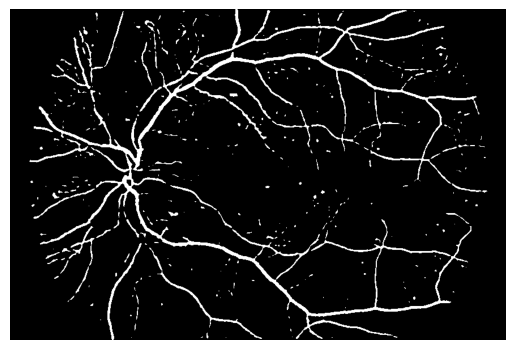

In [94]:
import matplotlib.pyplot as plt

# Wyświetlanie binarnej maski jako obrazu
plt.imshow(binary_mask_image[:,:,0], cmap='gray')  # Wyświetlenie pierwszego kanału
plt.axis('off') 
plt.show()

In [48]:
cv2.imshow("Obraz X_val[0]", y_pred[0])
cv2.waitKey(0)  # Wait for user input before closing the window
cv2.destroyAllWindows()

- 5 epochs result:

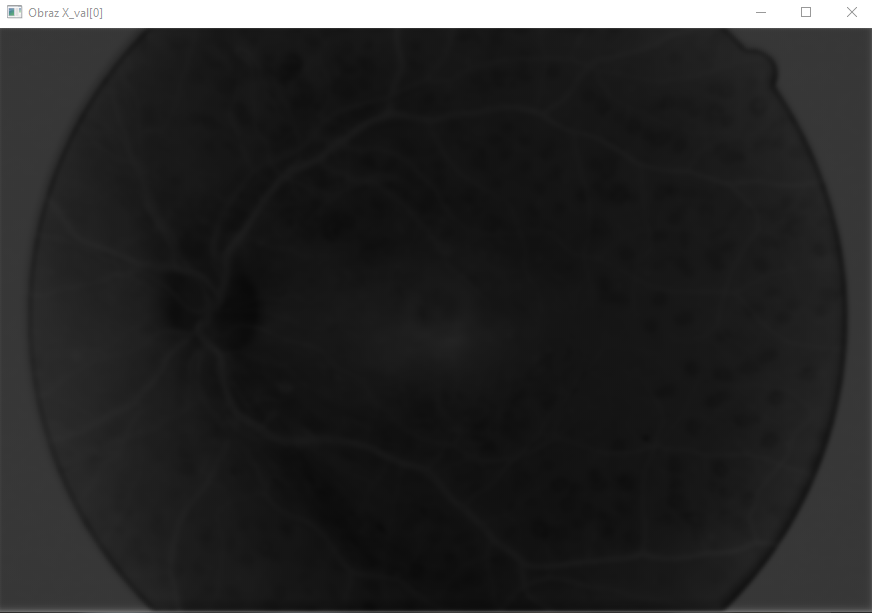

- 10 epochs result:

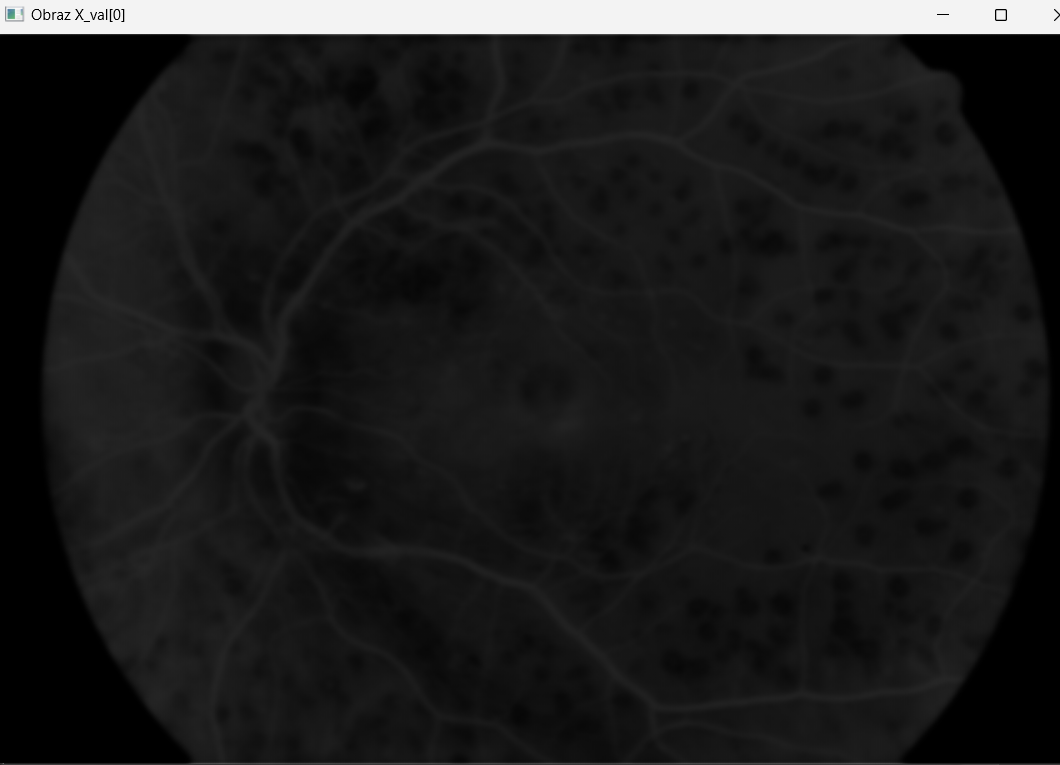

- 20 epochs:

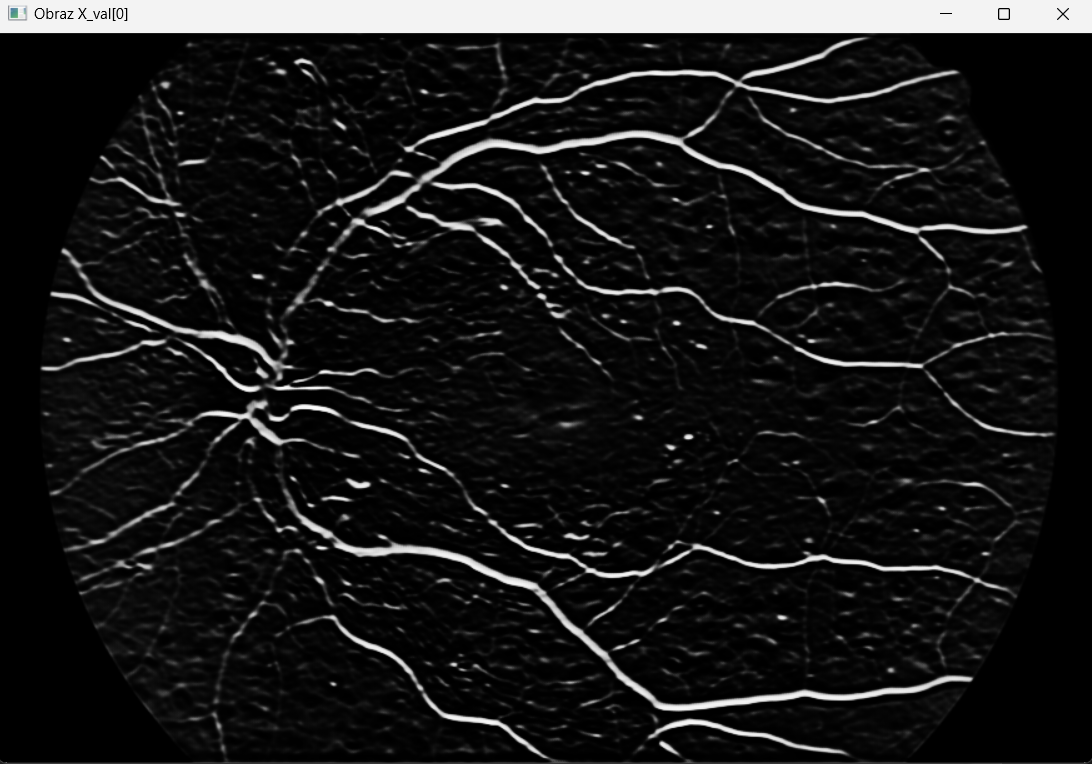

- 30 epochs:

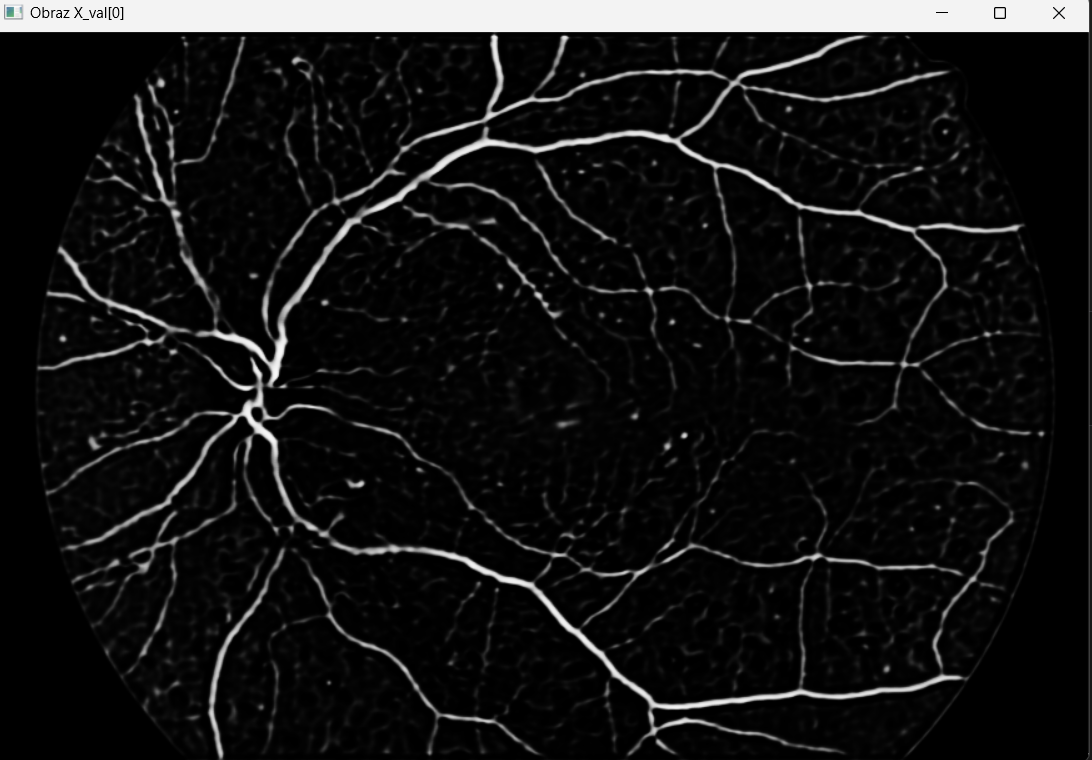

- 35 epochs:

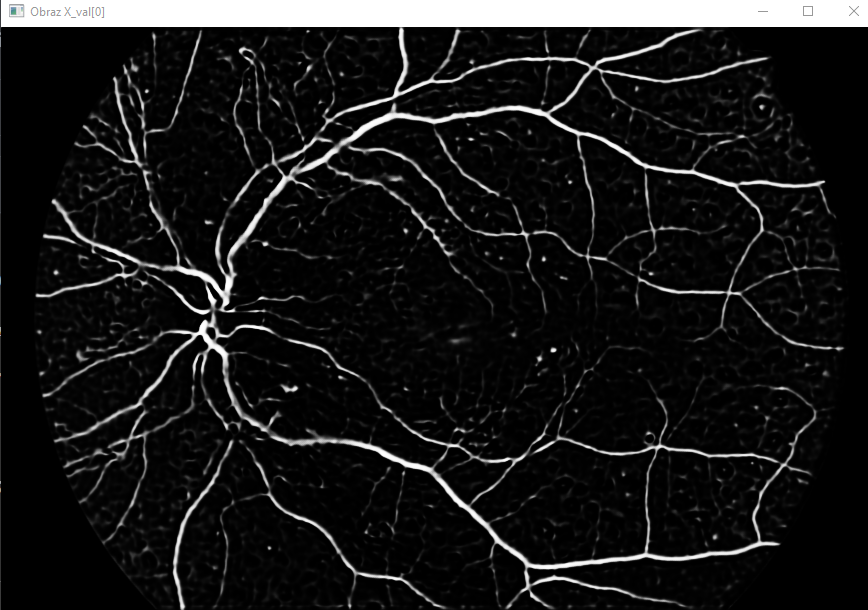 width='256'

- prediction & metrics functions

In [95]:
# Zastosowanie progu do binarnej segmentacji
def apply_threshold(pred, threshold=0.42):
  pred_bin = np.where(pred >= threshold, 1, 0)

  return pred_bin

# Obliczenie metryk klasyfikacji binarnej
def compare_pred_mask(pred, mask):
  # Konwersja predykcji i maski do formatu binarnego
  pred_bin = pred
  mask_bin = mask

  tp = np.sum(pred_bin * mask_bin)
  tn = np.sum((1 - pred_bin) * (1 - mask_bin))
  fp = np.sum(pred_bin * (1 - mask_bin))
  fn = np.sum((1 - pred_bin) * mask_bin)

  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 * (precision * recall) / (precision + recall)

  return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score}

- model evaluation:

In [96]:
# Obliczenie metryk dla każdego obrazu w zbiorze walidacyjnym
metrics_per_image = []
for i in range(len(X_val)):
  pred = y_pred[i][:, :, 0]
  mask = y_val[i][:, :, 0]

  # Zastosowanie progu
  pred_bin = apply_threshold(pred)

  # Obliczenie metryk
  metrics_per_image.append(compare_pred_mask(pred_bin, mask))

# średnie metryk
metrics_avg = {metric: np.mean([m[metric] for m in metrics_per_image]) for metric in metrics_per_image[0]}

# Wyświetlenie metryk
print("Metryki klasyfikacji:")
for metric, value in metrics_avg.items():
  print(f"{metric}: {value:.4f}")

Metryki klasyfikacji:
accuracy: 0.9583
precision: 0.8071
recall: 0.6342
f1_score: 0.7061


### 4. Wyniki dla przykładowych instancji

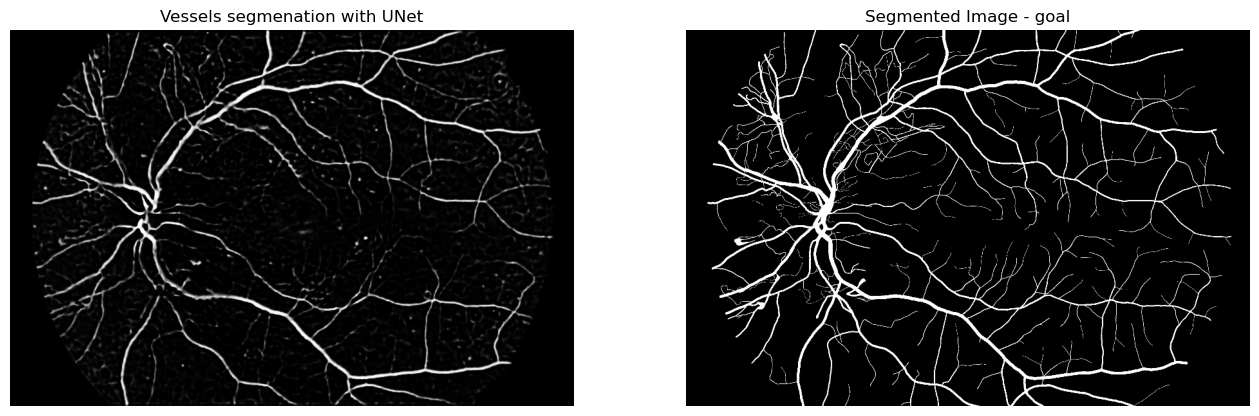

In [97]:
pred_1 = y_pred[0][:, :, 0]
mask_1 = y_val[0][:, :, 0]

plt.figure(figsize=(16, 12))

plt.subplot(1, 2, 1)
plt.imshow(pred_1, cmap='gray')
plt.title('Vessels segmenation with UNet')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_1, cmap='gray')
plt.title('Segmented Image - goal')
plt.axis('off')

plt.show()

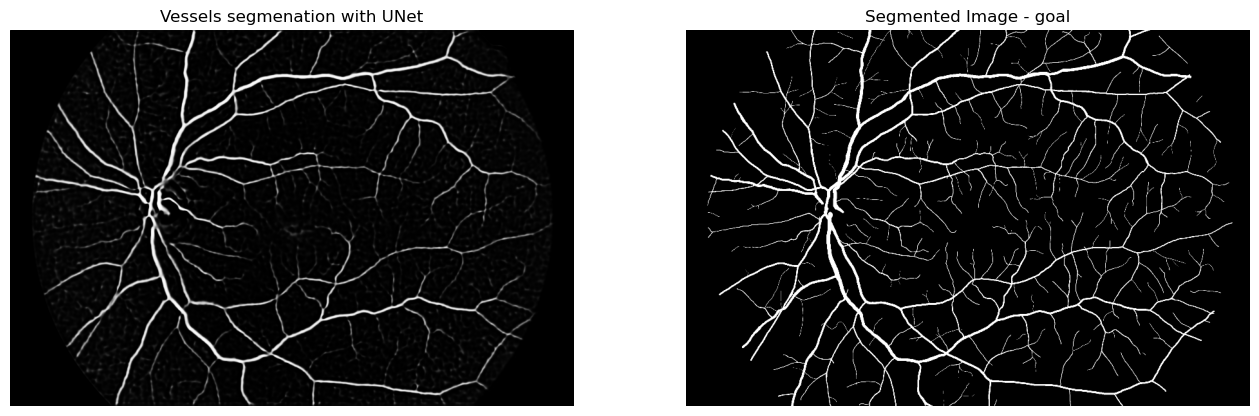

In [98]:
pred_2 = y_pred[1][:, :, 0]
mask_2 = y_val[1][:, :, 0]

plt.figure(figsize=(16, 12))

plt.subplot(1, 2, 1)
plt.imshow(pred_2, cmap='gray')
plt.title('Vessels segmenation with UNet')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_2, cmap='gray')
plt.title('Segmented Image - goal')
plt.axis('off')

plt.show()

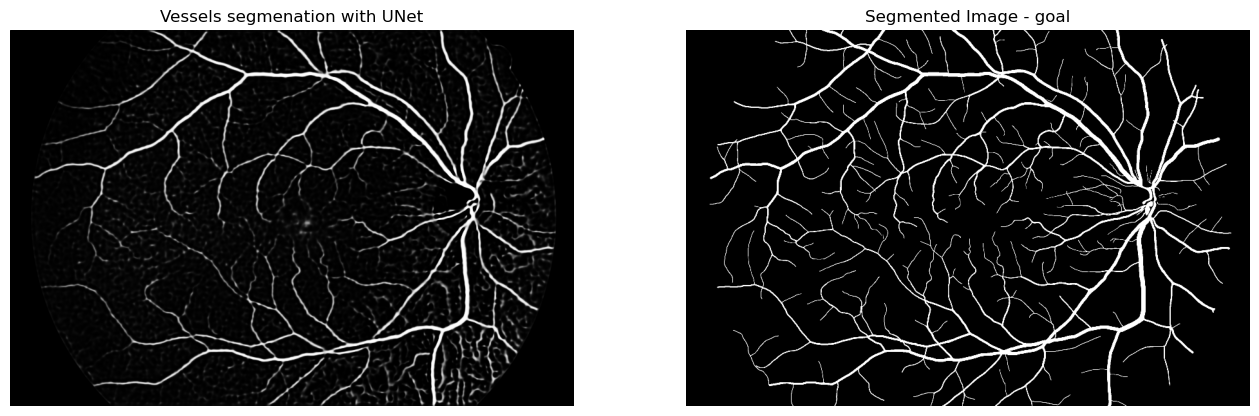

In [99]:
pred_3 = y_pred[2][:, :, 0]
mask_3 = y_val[2][:, :, 0]

plt.figure(figsize=(16, 12))

plt.subplot(1, 2, 1)
plt.imshow(pred_3, cmap='gray')
plt.title('Vessels segmenation with UNet')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_3, cmap='gray')
plt.title('Segmented Image - goal')
plt.axis('off')

plt.show()